# Implementing a Sentiment Analyzer


Sentiment analysis is the process of determining the sentiment of a given piece of text and is also referred to as Opinion Mining. It is one of the most popular applications of Natural Language Processing and it's mostly used in social media and customer reviews data. 

In this Notebook we are using sentiment analysis to determine whether a movie review is positive or negative. 

## 1. Import and download the data

We will use the NLTK's movie_reviews corpus as our labeled training data. The movie_reviews corpus contains 2K movie reviews with sentiment classification. 

First, we're going to use a Naive Bayes classifier. This is a pretty popular classifier used in text classification, sentiment analysis, spam filtering, etc. because it's very well suited to deal with high dimensional data (many many features / columns), even with a limited number of observations (rows). The curse of dimensionality dictates we need a lot of data samples/observations if we have a high dimensional data set, yet Naive Bayes will be able to get around this problem.

Along the way, we'll also demonstrate how to apply a neural network (because this is a deep learning item) to this kind of (high dimensional) data. A neural network is also pretty well suited for this kind of data, yet not as good as a Naive Bayes. That's why we'll also apply a dimensionality reduction technique (PCA) to our data, before classifying it with a neural network. This dimensionality reduction is out of scope for this course.

In [59]:
from nltk.corpus import movie_reviews 
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy as nltk_accuracy
from nltk.tokenize import word_tokenize

import nltk

You can download the data as follows. We will also download the English stopwords for later use.

In [60]:
nltk.download('movie_reviews')
nltk.download('stopwords')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\u0040810\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\u0040810\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2. Explore the data

We have two categories for classification: positive and negative. The movie_reviews corpus has already categorized the reviews  as positive or negative. As you can see there are 1,000 positive reviews and 1,000 negative ones.

In [61]:
# review categories
print (movie_reviews.categories())

# total reviews
print (len(movie_reviews.fileids()))
 
# total positive reviews
print (len(movie_reviews.fileids('pos')))
 
# total negative reviews
print (len(movie_reviews.fileids('neg')))
 
# print the name of the first positive review file
positive_review_file = movie_reviews.fileids('neg')[0] 
print (positive_review_file)

['neg', 'pos']
2000
1000
1000
neg/cv000_29416.txt


We can also print the content of a file. We can obtain all words in a review with the words(review_file)-method. Using the words()-method without any parameter, would return the words in all movie reviews.

In [62]:
for word in movie_reviews.words('neg/cv000_29416.txt'):
    print(word, end = ' ') # use a space instead of a linefeed after each word

plot : two teen couples go to a church party , drink and then drive . they get into an accident . one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . what ' s the deal ? watch the movie and " sorta " find out . . . critique : a mind - fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn ' t snag this one correctly . they seem to have taken this pretty neat concept , but executed it terribly . so what are the problems with the movie ? well , its main problem is that it ' s simply too jumbled . it starts off " normal " but then downshifts into this " fantasy " world in which you , as an audience member , have no idea

## 3. Data Preparation

Before we hand our data to a modelling algorithm, we first need to encode the information into a numerical vector, so we can calculate with it. The problem now is, how to encode lots of textual information, not just one label.

### Create a list of documents

First, execute the code below. We iterate over the two categories ('neg' and 'pos') and take all of the file IDs (each review has its own review file). Then we'll store the word_tokenized version (a list of words) of the file ID, followed by the positive or negative label, in one big list.

In [63]:
documents = []
for category in movie_reviews.categories():
    for fileid in movie_reviews.fileids(category):
        documents.append((list(movie_reviews.words(fileid)), category))

Just so you can see the outcome of the code above, we print out documents[0]: the first element is a list of words (from the first file), and the 2nd element is the "pos" or "neg" label (look at the end of the output).

In [64]:
print(documents[0])

(['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.', 'they', 'get', 'into', 'an', 'accident', '.', 'one', 'of', 'the', 'guys', 'dies', ',', 'but', 'his', 'girlfriend', 'continues', 'to', 'see', 'him', 'in', 'her', 'life', ',', 'and', 'has', 'nightmares', '.', 'what', "'", 's', 'the', 'deal', '?', 'watch', 'the', 'movie', 'and', '"', 'sorta', '"', 'find', 'out', '.', '.', '.', 'critique', ':', 'a', 'mind', '-', 'fuck', 'movie', 'for', 'the', 'teen', 'generation', 'that', 'touches', 'on', 'a', 'very', 'cool', 'idea', ',', 'but', 'presents', 'it', 'in', 'a', 'very', 'bad', 'package', '.', 'which', 'is', 'what', 'makes', 'this', 'review', 'an', 'even', 'harder', 'one', 'to', 'write', ',', 'since', 'i', 'generally', 'applaud', 'films', 'which', 'attempt', 'to', 'break', 'the', 'mold', ',', 'mess', 'with', 'your', 'head', 'and', 'such', '(', 'lost', 'highway', '&', 'memento', ')', ',', 'but', 'there', 'are', 'good', 'and', 'b

Next, we use random to shuffle our documents. This is because we're going to train and test. If we left them in order, we'd train on all the negatives, some positives, and then test only against positives. We don't want that, so we shuffle the data.

In [65]:
import random

random.shuffle(documents)

### Collect the top 3,000 words

Now, we want to collect all words that we found, so we have a massive list of typical words.

In [66]:
all_words = []
for w in movie_reviews.words():
    all_words.append(w.lower())

From here, we can perform a frequency distribution, to find out the most common words. As you will see, the most popular "words" are actually things like punctuation, "the," "a" and so on.

In [67]:
word_frequency = nltk.FreqDist(all_words)
print(word_frequency.most_common(100))

[(',', 77717), ('the', 76529), ('.', 65876), ('a', 38106), ('and', 35576), ('of', 34123), ('to', 31937), ("'", 30585), ('is', 25195), ('in', 21822), ('s', 18513), ('"', 17612), ('it', 16107), ('that', 15924), ('-', 15595), (')', 11781), ('(', 11664), ('as', 11378), ('with', 10792), ('for', 9961), ('his', 9587), ('this', 9578), ('film', 9517), ('i', 8889), ('he', 8864), ('but', 8634), ('on', 7385), ('are', 6949), ('t', 6410), ('by', 6261), ('be', 6174), ('one', 5852), ('movie', 5771), ('an', 5744), ('who', 5692), ('not', 5577), ('you', 5316), ('from', 4999), ('at', 4986), ('was', 4940), ('have', 4901), ('they', 4825), ('has', 4719), ('her', 4522), ('all', 4373), ('?', 3771), ('there', 3770), ('like', 3690), ('so', 3683), ('out', 3637), ('about', 3523), ('up', 3405), ('more', 3347), ('what', 3322), ('when', 3258), ('which', 3161), ('or', 3148), ('she', 3141), ('their', 3122), (':', 3042), ('some', 2985), ('just', 2905), ('can', 2882), ('if', 2799), ('we', 2775), ('him', 2633), ('into', 2

Let's try to clean up things a little bit.

In [68]:
from nltk.corpus import stopwords 
import string 
 
stopwords_english = stopwords.words('english')

words_clean = []
 
for word in all_words:
    word = word.lower()
    if word not in stopwords_english and word not in string.punctuation:
        words_clean.append(word)

You can find out how many occurrences a word has.

In [69]:
word_frequency = nltk.FreqDist(words_clean)
print(word_frequency.most_common(100))
print(word_frequency["stupid"])

[('film', 9517), ('one', 5852), ('movie', 5771), ('like', 3690), ('even', 2565), ('good', 2411), ('time', 2411), ('story', 2169), ('would', 2109), ('much', 2049), ('character', 2020), ('also', 1967), ('get', 1949), ('two', 1911), ('well', 1906), ('characters', 1859), ('first', 1836), ('--', 1815), ('see', 1749), ('way', 1693), ('make', 1642), ('life', 1586), ('really', 1558), ('films', 1536), ('plot', 1513), ('little', 1501), ('people', 1455), ('could', 1427), ('scene', 1397), ('man', 1396), ('bad', 1395), ('never', 1374), ('best', 1333), ('new', 1292), ('scenes', 1274), ('many', 1268), ('director', 1237), ('know', 1217), ('movies', 1206), ('action', 1172), ('great', 1148), ('another', 1121), ('love', 1119), ('go', 1113), ('made', 1084), ('us', 1073), ('big', 1064), ('end', 1062), ('something', 1061), ('back', 1060), ('still', 1047), ('world', 1037), ('seems', 1033), ('work', 1020), ('makes', 992), ('however', 989), ('every', 947), ('though', 940), ('better', 922), ('real', 915), ('aud

This looks much better. Let's make a new variable, top_words, which contains the top 3,000 most common words.

In [70]:
top_words = list(word_frequency.keys())[:3000]
print(top_words)

['plot', 'two', 'teen', 'couples', 'go', 'church', 'party', 'drink', 'drive', 'get', 'accident', 'one', 'guys', 'dies', 'girlfriend', 'continues', 'see', 'life', 'nightmares', 'deal', 'watch', 'movie', 'sorta', 'find', 'critique', 'mind', 'fuck', 'generation', 'touches', 'cool', 'idea', 'presents', 'bad', 'package', 'makes', 'review', 'even', 'harder', 'write', 'since', 'generally', 'applaud', 'films', 'attempt', 'break', 'mold', 'mess', 'head', 'lost', 'highway', 'memento', 'good', 'ways', 'making', 'types', 'folks', 'snag', 'correctly', 'seem', 'taken', 'pretty', 'neat', 'concept', 'executed', 'terribly', 'problems', 'well', 'main', 'problem', 'simply', 'jumbled', 'starts', 'normal', 'downshifts', 'fantasy', 'world', 'audience', 'member', 'going', 'dreams', 'characters', 'coming', 'back', 'dead', 'others', 'look', 'like', 'strange', 'apparitions', 'disappearances', 'looooot', 'chase', 'scenes', 'tons', 'weird', 'things', 'happen', 'explained', 'personally', 'trying', 'unravel', 'film

### Create the featureset

We're going to build a function that will find these top 3,000 words in our positive and negative documents, marking their presence either positive or negative.

In [71]:
def find_top_words(words):
    wordset = set(words)
    result = {}
    for w in top_words:
        result[w] = (w in wordset) # true if top_word is occurring in the wordset

    return result

Next we can create an object with all the top 3,000 words and an indication whether the word is present in the review.

In [72]:
print((find_top_words(movie_reviews.words('neg/cv000_29416.txt'))))

{'plot': True, 'two': True, 'teen': True, 'couples': True, 'go': True, 'church': True, 'party': True, 'drink': True, 'drive': True, 'get': True, 'accident': True, 'one': True, 'guys': True, 'dies': True, 'girlfriend': True, 'continues': True, 'see': True, 'life': True, 'nightmares': True, 'deal': True, 'watch': True, 'movie': True, 'sorta': True, 'find': True, 'critique': True, 'mind': True, 'fuck': True, 'generation': True, 'touches': True, 'cool': True, 'idea': True, 'presents': True, 'bad': True, 'package': True, 'makes': True, 'review': True, 'even': True, 'harder': True, 'write': True, 'since': True, 'generally': True, 'applaud': True, 'films': True, 'attempt': True, 'break': True, 'mold': True, 'mess': True, 'head': True, 'lost': True, 'highway': True, 'memento': True, 'good': True, 'ways': True, 'making': True, 'types': True, 'folks': True, 'snag': True, 'correctly': True, 'seem': True, 'taken': True, 'pretty': True, 'neat': True, 'concept': True, 'executed': True, 'terribly': T

Finally we can do this for all of our documents, saving the word existence booleans and their respective positive or negative categories (have a look at the end of the output).

In [73]:
featuresets = []
for (words, category) in documents:
    featuresets.append((find_top_words(words), category))

In [74]:
print(featuresets[0])

({'plot': False, 'two': True, 'teen': False, 'couples': False, 'go': False, 'church': False, 'party': False, 'drink': False, 'drive': False, 'get': True, 'accident': True, 'one': True, 'guys': False, 'dies': False, 'girlfriend': False, 'continues': False, 'see': True, 'life': False, 'nightmares': False, 'deal': True, 'watch': False, 'movie': True, 'sorta': False, 'find': False, 'critique': False, 'mind': False, 'fuck': False, 'generation': False, 'touches': False, 'cool': False, 'idea': False, 'presents': True, 'bad': False, 'package': False, 'makes': False, 'review': False, 'even': True, 'harder': False, 'write': False, 'since': False, 'generally': False, 'applaud': False, 'films': True, 'attempt': False, 'break': False, 'mold': False, 'mess': False, 'head': False, 'lost': False, 'highway': False, 'memento': False, 'good': True, 'ways': False, 'making': True, 'types': False, 'folks': False, 'snag': False, 'correctly': False, 'seem': False, 'taken': False, 'pretty': True, 'neat': False

As you can see, we are using the top 3,000 words as input features for our classifier (the value of the feature is a boolean indicating whether the word exists in the document). The output feature or label is "pos" or "neg" indicating whether the review is positive of negative.

Now, we're ready to hand our data to our modeling algorithm!

## 4. Train the classifier 

Now it is time to choose an algorithm, separate our data into training and testing sets, and press go! The algorithm that we're going to use is the Naive Bayes classifier. This is a pretty popular algorithm used in text classification, sentiment analysis, spam filtering, ...

In [75]:
# training set that we'll train our classifier with
training_set = featuresets[:1900]

# testing set that we'll test against.
testing_set = featuresets[1900:]

Train a Naive Bayes classifier using the training data and compute the accuracy using the build-in method available in NLTK. (for more info: https://www.nltk.org/_modules/nltk/classify/naivebayes.html)

In [76]:
classifier = nltk.NaiveBayesClassifier.train(training_set)
print('\nAccuracy of the classifier:', nltk_accuracy(classifier, testing_set))


Accuracy of the classifier: 0.78


We can take it a step further to see what the most valuable words are when it comes to positive or negative reviews.

In [77]:
classifier.show_most_informative_features(15)

Most Informative Features
                   sucks = True              neg : pos    =     10.5 : 1.0
                  annual = True              pos : neg    =      9.8 : 1.0
                bothered = True              neg : pos    =      9.5 : 1.0
                 frances = True              pos : neg    =      9.1 : 1.0
           unimaginative = True              neg : pos    =      8.2 : 1.0
                   groan = True              neg : pos    =      7.6 : 1.0
             silverstone = True              neg : pos    =      7.6 : 1.0
              schumacher = True              neg : pos    =      6.9 : 1.0
                 idiotic = True              neg : pos    =      6.7 : 1.0
                  turkey = True              neg : pos    =      6.5 : 1.0
                 cunning = True              pos : neg    =      6.4 : 1.0
                obstacle = True              pos : neg    =      6.4 : 1.0
                 singers = True              pos : neg    =      6.4 : 1.0

We can see that the term "sucks" appears 10.7 more times as often in negative reviews as it does in positive reviews. You might get another value since we randomly shuffled our documents before splitting the train and test data.
 
We also can print the most informative features in a list.

In [78]:
N = 15
print('\nTop ' + str(N) + ' most informative words:')
for i, item in enumerate(classifier.most_informative_features(N)):
    print(str(i+1) + '. ' + item[0])


Top 15 most informative words:
1. sucks
2. annual
3. bothered
4. frances
5. unimaginative
6. groan
7. silverstone
8. schumacher
9. idiotic
10. turkey
11. cunning
12. obstacle
13. singers
14. regard
15. jumbo


## 5. Train a Neural Network (deep learning)
### Prep the data for a neural network
 
Our deep learning library, Keras, requires our data to be in the form of a pandas dataframe. And, because in our data so far, a feature is either there ('True'), or not there ('False'), we'll also encode it in a 'one-hot-encoded' fashion (True = 1, False = 0).

So, let's try and convert it into a proper one hot encoded pandas dataframe.

In [79]:
print(featuresets[0])

({'plot': False, 'two': True, 'teen': False, 'couples': False, 'go': False, 'church': False, 'party': False, 'drink': False, 'drive': False, 'get': True, 'accident': True, 'one': True, 'guys': False, 'dies': False, 'girlfriend': False, 'continues': False, 'see': True, 'life': False, 'nightmares': False, 'deal': True, 'watch': False, 'movie': True, 'sorta': False, 'find': False, 'critique': False, 'mind': False, 'fuck': False, 'generation': False, 'touches': False, 'cool': False, 'idea': False, 'presents': True, 'bad': False, 'package': False, 'makes': False, 'review': False, 'even': True, 'harder': False, 'write': False, 'since': False, 'generally': False, 'applaud': False, 'films': True, 'attempt': False, 'break': False, 'mold': False, 'mess': False, 'head': False, 'lost': False, 'highway': False, 'memento': False, 'good': True, 'ways': False, 'making': True, 'types': False, 'folks': False, 'snag': False, 'correctly': False, 'seem': False, 'taken': False, 'pretty': True, 'neat': False

In [80]:
training_set
# Convert the features from True/False to 1/0
featuresets = [ ({k: int (v) for k, v in features.items ()}, label) for features, label in featuresets]


In [81]:
print(featuresets[0])

({'plot': 0, 'two': 1, 'teen': 0, 'couples': 0, 'go': 0, 'church': 0, 'party': 0, 'drink': 0, 'drive': 0, 'get': 1, 'accident': 1, 'one': 1, 'guys': 0, 'dies': 0, 'girlfriend': 0, 'continues': 0, 'see': 1, 'life': 0, 'nightmares': 0, 'deal': 1, 'watch': 0, 'movie': 1, 'sorta': 0, 'find': 0, 'critique': 0, 'mind': 0, 'fuck': 0, 'generation': 0, 'touches': 0, 'cool': 0, 'idea': 0, 'presents': 1, 'bad': 0, 'package': 0, 'makes': 0, 'review': 0, 'even': 1, 'harder': 0, 'write': 0, 'since': 0, 'generally': 0, 'applaud': 0, 'films': 1, 'attempt': 0, 'break': 0, 'mold': 0, 'mess': 0, 'head': 0, 'lost': 0, 'highway': 0, 'memento': 0, 'good': 1, 'ways': 0, 'making': 1, 'types': 0, 'folks': 0, 'snag': 0, 'correctly': 0, 'seem': 0, 'taken': 0, 'pretty': 1, 'neat': 0, 'concept': 0, 'executed': 0, 'terribly': 0, 'problems': 1, 'well': 1, 'main': 0, 'problem': 1, 'simply': 0, 'jumbled': 0, 'starts': 0, 'normal': 0, 'downshifts': 0, 'fantasy': 0, 'world': 1, 'audience': 0, 'member': 0, 'going': 0, 'd

In [82]:
import pandas as pd

# Create a DataFrame from the list of tuples
df = pd.DataFrame.from_records (featuresets, columns= ['features', 'label'])


In [83]:
df

,features,label
0,"{'plot': 0, 'two': 1, 'teen': 0, 'couples': 0,...",pos
1,"{'plot': 0, 'two': 0, 'teen': 0, 'couples': 0,...",neg
2,"{'plot': 1, 'two': 0, 'teen': 1, 'couples': 0,...",neg
3,"{'plot': 0, 'two': 0, 'teen': 0, 'couples': 1,...",pos
4,"{'plot': 0, 'two': 1, 'teen': 0, 'couples': 0,...",neg
...,...,...
1995,"{'plot': 1, 'two': 1, 'teen': 0, 'couples': 0,...",pos
1996,"{'plot': 0, 'two': 1, 'teen': 0, 'couples': 0,...",pos
1997,"{'plot': 1, 'two': 0, 'teen': 0, 'couples': 0,...",pos
1998,"{'plot': 1, 'two': 1, 'teen': 0, 'couples': 0,...",neg


In [84]:
# Expand the features column into separate columns
df = df.apply (lambda x: pd.Series (x ['features']), axis=1).join (df ['label'])
# Drop the features column
df = df.drop ('features', axis=1)



In [85]:
df

,plot,two,teen,couples,go,church,party,drink,drive,get,...,imposing,volkswagen,feet,larger,pro,player,bellows,poachers,millions,label
0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,pos
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,neg
2,1,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,neg
3,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,pos
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,1,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,pos
1996,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,pos
1997,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,pos
1998,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,neg


In [86]:
# Replace positive with 1 and negative with 0
df ['label'] = df ['label'].replace ( {'pos': 1, 'neg': 0})

In [87]:
df

,plot,two,teen,couples,go,church,party,drink,drive,get,...,imposing,volkswagen,feet,larger,pro,player,bellows,poachers,millions,label
0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,1,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1996,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1997,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1998,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
y = df['label']
X = df.drop('label', axis = 1)

### Dimensionality reduction (PCA) - out of scope for this course

Okay, our data is almost ready to be handed to a neural network. But...there are way too many dimensions for the numnber of observations there are (3k dimensions, 2k rows). Damn you, curse of dimensionality!!!

So, let's reduce the dimensionality, by compressing the data into the most import (newly created) dimensions, using a technique called 'Principal Component Analysis'. Aka, in mathematics this is linked to the concept of 'eigen-vectors'.

We can define how many 'compression dimensions' it should use. Let's say 10 dimensions (so compress from 3000 to 10, using a mathematical 'compression')


In [89]:
from sklearn.decomposition import PCA
pca = PCA (n_components=10)
X_pca = pca.fit_transform (X)
X_pca

array([[-0.63090074,  1.78917945, -1.27575501, ...,  0.58954087,
         0.14846439,  0.47008755],
       [ 0.30790919, -0.05127091,  0.16517988, ..., -0.54668973,
        -0.24932161, -0.74378321],
       [-1.54927929,  0.40232422, -0.20655387, ..., -0.62598824,
        -0.59578924, -0.01607714],
       ...,
       [ 1.81725873,  1.32950107, -0.71012437, ..., -0.16563072,
        -1.3899001 , -0.73104118],
       [ 0.98776737, -2.86835034, -1.48450645, ...,  0.07051479,
        -1.70906682,  1.71598925],
       [ 4.82007058, -1.28637436, -0.50512412, ..., -0.28929656,
        -0.30355224, -0.33369348]])

In [90]:
X_pca_df = pd.DataFrame(X_pca)
X_pca_df

,0,1,2,3,4,5,6,7,8,9
0,-0.630901,1.789179,-1.275755,0.831314,-0.029625,0.243550,-1.348355,0.589541,0.148464,0.470088
1,0.307909,-0.051271,0.165180,-0.663644,0.850044,0.967287,-2.315005,-0.546690,-0.249322,-0.743783
2,-1.549279,0.402324,-0.206554,0.362725,0.717190,0.070040,-0.954461,-0.625988,-0.595789,-0.016077
3,1.597177,2.434513,-0.787084,0.426982,-0.103083,0.240675,-1.443669,1.499863,0.529699,0.327533
4,-0.006489,0.957181,1.543182,0.040423,-0.182171,0.805576,-0.832530,-1.642884,-0.283364,-0.970423
...,...,...,...,...,...,...,...,...,...,...
1995,2.373302,1.573679,0.377196,-0.010506,1.146609,-1.679961,-0.473909,1.337455,1.333736,0.213795
1996,-1.692096,-0.353996,-1.017069,-0.053833,-0.247058,-0.035889,-0.234251,-0.417065,0.266412,0.402625
1997,1.817259,1.329501,-0.710124,0.940090,-0.017563,-0.327745,-0.656020,-0.165631,-1.389900,-0.731041
1998,0.987767,-2.868350,-1.484506,0.858968,-0.660268,0.610099,0.127925,0.070515,-1.709067,1.715989


In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca_df, y, test_size=0.2, random_state=0)

In [92]:
X_train

,0,1,2,3,4,5,6,7,8,9
582,0.465023,-0.653473,1.532401,1.394708,0.115814,0.554870,0.779858,-0.587672,-0.726500,0.257296
159,-0.043321,-0.574553,0.304405,0.155513,1.242638,0.549251,0.146059,0.362613,-0.008794,-0.034817
1827,2.987983,1.584340,-1.956763,1.808290,-0.599038,1.048750,0.515920,-0.171941,0.133807,0.248839
318,0.423225,1.209142,-1.007359,0.886553,1.077545,0.137231,1.032890,0.618876,-0.218510,-0.046153
708,-0.681667,0.081642,-0.397489,0.032157,0.251955,-0.210698,1.354796,-0.019021,0.405767,-0.411421
...,...,...,...,...,...,...,...,...,...,...
835,-1.540154,-0.004832,0.454079,0.339711,-0.347144,-0.008223,0.042517,-0.153176,0.918458,0.376897
1216,-3.320098,0.253066,-0.584045,-0.194066,0.210130,0.023370,0.857496,0.366806,-0.238505,0.580238
1653,0.122029,-1.756713,-0.438463,-0.890984,-0.290280,1.088226,0.449776,-0.779030,0.226097,0.230535
559,1.303969,-0.923297,-0.462835,-0.965656,0.398245,-0.431554,0.100010,0.122397,0.508245,-1.114392


In [93]:
number_cols = X_train.shape[1]
print(number_cols)

10


In [94]:
y_train

582     0
159     0
1827    1
318     0
708     0
       ..
835     1
1216    0
1653    0
559     0
684     0
Name: label, Length: 1600, dtype: int64

In [95]:
# Check the type of X_train and y_train
print (type (X_train))
print (type (y_train))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [96]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers

model = keras.Sequential([
    # Input Layer: Add a Flattening layer to make 1-D vector of our 28x28 images
    layers.Flatten(input_shape=(number_cols, )),
    # Hidden layer: Add a Dense layer, aka a fully or densely connected layer of 50 neurons
    layers.Dense(50, activation='relu'),
    # Output layer: Add a Dense layer of 1 neuron 
    layers.Dense(1, activation='sigmoid')
])

In [97]:
# Compile the model with the optimizer, loss, and metrics
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [98]:
history = model.fit(X_train, y_train, epochs=20, batch_size=50, validation_split=0.2)

Epoch 1/20


26/26 [==============================] - 1s 8ms/step - loss: 0.7122 - accuracy: 0.4984 - val_loss: 0.6710 - val_accuracy: 0.5750
Epoch 2/20
26/26 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6477 - val_loss: 0.6267 - val_accuracy: 0.6938
Epoch 3/20
26/26 [==============================] - 0s 3ms/step - loss: 0.6034 - accuracy: 0.7289 - val_loss: 0.5934 - val_accuracy: 0.7031
Epoch 4/20
26/26 [==============================] - 0s 3ms/step - loss: 0.5671 - accuracy: 0.7586 - val_loss: 0.5689 - val_accuracy: 0.7094
Epoch 5/20
26/26 [==============================] - 0s 3ms/step - loss: 0.5401 - accuracy: 0.7609 - val_loss: 0.5503 - val_accuracy: 0.7125
Epoch 6/20
26/26 [==============================] - 0s 3ms/step - loss: 0.5193 - accuracy: 0.7703 - val_loss: 0.5359 - val_accuracy: 0.7094
Epoch 7/20
26/26 [==============================] - 0s 3ms/step - loss: 0.5043 - accuracy: 0.7695 - val_loss: 0.5273 - val_accuracy: 0.7063
Epoch 8/20
26/26 [=============

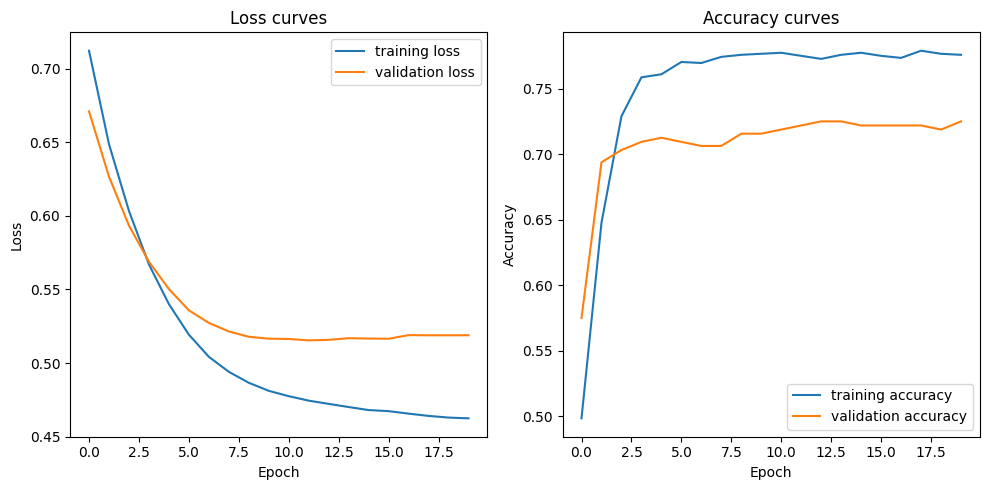

In [99]:
import matplotlib.pyplot as plt
# Create a figure and a grid of subplots with a single call
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot the loss curves on the first subplot
ax1.plot(history.history['loss'], label='training loss')
ax1.plot(history.history['val_loss'], label='validation loss')
ax1.set_title('Loss curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the accuracy curves on the second subplot
ax2.plot(history.history['accuracy'], label='training accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
ax2.set_title('Accuracy curves')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust the spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()

In [100]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

 1/13 [=>............................] - ETA: 0s - loss: 0.4462 - accuracy: 0.8125

13/13 [==============================] - 0s 2ms/step - loss: 0.4831 - accuracy: 0.7800
Test accuracy: 0.7799999713897705


As you can see: very comparable to the Naive Bayes classifier...

## 6. Test the classifier with custom reviews

We provide custom review texts and check the classification output of the trained classifier, using the Naive Bayes model. Will the classifier correctly predict both negative and positive reviews provided?

In [101]:
# test input movie reviews
input_reviews = [
    'The costumes in this movie were great.',
    'I think the story was terrible and the characters were very weak.',
    'People say that the director of the movie is amazing. It was a wonderful movie.',
    'This is such an idiotic movie. I will not recommend it to anyone.',
    'It doesn\'t matter how much you enjoy kung-fu and karate films: with 47 Ronin, you\'re better off saving your money, your popcorn, and time.',
    'Majili is the rare movie that succeeds fully on almost every level, where each character, scene, costume, and joke firing on all cylinders to make this great film worth repeated viewings.',
    'Despite a compelling lead performance by Tom Hanks, Forrest Gump never gets out of the shadow of its weak plot and questionable crappy premise.'
]

In [102]:
def cleanup_words(text):
    words = word_tokenize(text)
    
    words_clean = []
    for word in words:
        word = word.lower()
        if word not in stopwords_english and word not in string.punctuation:
            words_clean.append(word)
    
    words_dictionary = dict([word, True] for word in words_clean)  
    return words_dictionary

print("\nMovie review predictions:")
for review in input_reviews:
    print("\nReview:", review)

    # Compute the probabilities
    probabilities = classifier.prob_classify(cleanup_words(review))

    # Pick the maximum value
    predicted_sentiment = probabilities.max()

    # Print outputs
    print("Predicted sentiment:", predicted_sentiment)
    print("Probability:", round(probabilities.prob(predicted_sentiment), 2))


Movie review predictions:

Review: The costumes in this movie were great.
Predicted sentiment: pos
Probability: 0.64

Review: I think the story was terrible and the characters were very weak.
Predicted sentiment: neg
Probability: 0.83

Review: People say that the director of the movie is amazing. It was a wonderful movie.
Predicted sentiment: pos
Probability: 0.71

Review: This is such an idiotic movie. I will not recommend it to anyone.
Predicted sentiment: neg
Probability: 0.9

Review: It doesn't matter how much you enjoy kung-fu and karate films: with 47 Ronin, you're better off saving your money, your popcorn, and time.
Predicted sentiment: neg
Probability: 0.56

Review: Majili is the rare movie that succeeds fully on almost every level, where each character, scene, costume, and joke firing on all cylinders to make this great film worth repeated viewings.
Predicted sentiment: pos
Probability: 0.68

Review: Despite a compelling lead performance by Tom Hanks, Forrest Gump never gets

# 7. Running a SOTA NLP Sentiment Classifier

Out of scope for this course.

Just as a treat, let's run a State Of The Art (SOTA) NLP Sentiment Classifier on our input_reviews as well. We'll be using the HuggingFace Transformer library, which hold a lot of pre-trained models. Each model needs it's own pre-and post-processing (since each model is pre-trained in it's own way, and we need to duplicate this setting to run our data reliably through the model), but luckily HuggingFace provides us with a very nice pipeline()-function. This is an abstraction functionality, where we only need to input our raw text, and it will automaticcally apply the necessary steps to run it through the model

In [2]:
pip install --upgrade transformers[sentencepiece]

  Obtaining dependency information for transformers[sentencepiece] from https://files.pythonhosted.org/packages/c1/bd/f64d67df4d3b05a460f281defe830ffab6d7940b7ca98ec085e94e024781/transformers-4.34.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/121.5 kB ? eta -:--:--
     -------------------------------------- 121.5/121.5 kB 3.5 MB/s eta 0:00:00
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/5e/5d/97afbafd9d584ff1b45fcb354a479a3609bd97f912f8f1f6c563cb1fae21/filelock-3.12.4-py3-none-any.whl.metadata
  Obtaining dependency information for huggingface-hub<1.0,>=0.16.4 from https://files.pythonhosted.org/packages/ef/b5/b6107bd65fa4c96fdf00e4733e2fe5729bb9e5e09997f63074bb43d3ab28/huggingface_hub-0.18.0-py3-none-any.whl.metadata
  Obtaining dependency information for pyyaml>=5.1 from https://files.pythonhosted.org/packages/24/97/9b59b43431f98d01806b288532da38099cc6f2fea0f3d712e21e269c0279/PyYAML-6.0.1-cp310-cp310-win


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install tensorflow-text

     ---------------------------------------- 0.0/5.0 MB ? eta -:--:--
      --------------------------------------- 0.1/5.0 MB 6.8 MB/s eta 0:00:01
     ---- ----------------------------------- 0.6/5.0 MB 7.9 MB/s eta 0:00:01
     -------- ------------------------------- 1.0/5.0 MB 8.3 MB/s eta 0:00:01
     -------- ------------------------------- 1.0/5.0 MB 8.3 MB/s eta 0:00:01
     -------- ------------------------------- 1.0/5.0 MB 8.3 MB/s eta 0:00:01
     -------- ------------------------------- 1.0/5.0 MB 8.3 MB/s eta 0:00:01
     -------- ------------------------------- 1.0/5.0 MB 8.3 MB/s eta 0:00:01
     ----------- ---------------------------- 1.4/5.0 MB 3.8 MB/s eta 0:00:01
     -------------- ------------------------- 1.8/5.0 MB 4.5 MB/s eta 0:00:01
     ---------------- ----------------------- 2.0/5.0 MB 4.4 MB/s eta 0:00:01
     ------------------ --------------------- 2.3/5.0 MB 4.7 MB/s eta 0:00:01
     ------------------------ --------------- 3.0/5.0 MB 5.5 MB/s eta 0

ERROR: Could not install packages due to an OSError: [WinError 4393] The tag present in the reparse point buffer is invalid: 'c:\\users\\u0040810\\onedrive - thomas more\\ai project\\2023_2024\\dl_env\\lib\\site-packages\\keras\\api\\_v1\\keras\\applications\\nasnet'


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis")
classifier("I love this movie!")


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
c:\Users\u0040810\OneDrive - Thomas More\AI Project\2023_2024\DL_env\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\u0040810\.cache\huggingface\hub. Caching files will still work but in 

[{'label': 'POSITIVE', 'score': 0.9998775720596313}]